## Notebook to plot the results of the fitting routine tests

In [1]:
import matplotlib.pyplot as plt
import pickle, bz2
import numpy as np
from scipy.interpolate import interp1d

%matplotlib notebook

#### Setup cell

In [2]:
dirsave = '/user/gennaro/Functional_work/Up_the_ramp_myfork/Simulations_results/'
testname = '1'

In [3]:
outputs_file = dirsave+'Test_'+testname+'_out.pbz2'
inputs_file  = dirsave+'Test_'+testname+'_in.pbz2'

#### Restore the svaed files and prepare all variables

In [4]:
with bz2.BZ2File(outputs_file, 'rb') as f:
    dictoload = pickle.load(f)

goodints_l        =  dictoload['goodints_l']
counter_l         =  dictoload['counter_l']
error_l           =  dictoload['error_l']
crloops_counter_l =  dictoload['crloops_counter_l']
outerate_l        =  dictoload['outerate_l']
gof_stat_l        =  dictoload['gof_stat_l']
gof_pval_l        =  dictoload['gof_pval_l']


with bz2.BZ2File(inputs_file, 'rb') as f:
    dictoload = pickle.load(f)

meas_l     = dictoload['meas_l']
myfluxes   = dictoload['myfluxes']
myramps    = dictoload['myramps']
myCRrates  = dictoload['myCRrates']
mybgs      = dictoload['mybgs']
CRdict_l   = dictoload['CRdict_l']
extra_bg_l = dictoload['extra_bg_l']

del(dictoload)

#Unpack the lists to regroup items by ramp

ntest = len(meas_l)//len(myramps)

gi_list  = [np.empty([ntest,mm.group_times.size-1],dtype=np.bool_) for mm in myramps]
CR_list   = [[[] for _ in range(ntest)] for mm in myramps]
meas_list = [[[] for _ in range(ntest)] for mm in myramps]
ebg_list  = [[[] for _ in range(ntest)] for mm in myramps]

counter  = np.empty([ntest,len(myfluxes)],dtype=np.int_)
error    = np.empty([ntest,len(myfluxes)],dtype=np.int_)
outerate = np.empty([ntest,len(myfluxes)])
crloops_counter  = np.empty([ntest,len(myfluxes)],dtype=np.int_)
gof_stat = np.empty([ntest,len(myfluxes)],dtype=np.int_)
gof_pval = np.empty([ntest,len(myfluxes)])

for l,(g,C,m,c,e,cc,o,gs,gp,eb) in enumerate(zip(goodints_l,CRdict_l,meas_l,counter_l,error_l,crloops_counter_l,outerate_l,gof_stat_l,gof_pval_l,extra_bg_l)):

    k = l % ntest
    j = l // ntest
    
    counter[k,j]  = c
    error[k,j]    = e
    crloops_counter[k,j] = cc
    outerate[k,j] = o
    gof_stat[k,j] = gs
    gof_pval[k,j] = gp

    gi_list[j][k,:] = g
    CR_list[j][k]   = C
    meas_list[j][k] = m
    ebg_list[j][k]  = eb
    


#### Regroup all the simulated CRhits and check whether they have been detected

In [5]:
allCRtimes = []
allCRcounts = []
allCRdetect = []

ramps_with_CRs = []

for j,(myflux,myramp) in enumerate(zip(myfluxes,myramps)):

    allCRtimes_p = []
    allCRcounts_p = []
    allCRdetect_p = []
    ramps_with_CRs_p = np.zeros(len(CR_list[j]),dtype=np.bool_)
    
    CRlist_p = CR_list[j]
    for i,dd in enumerate(CRlist_p):
        if dd is not None:
            ramps_with_CRs_p[i] = True
            allCRtimes_p.extend(dd['times'])
            allCRcounts_p.extend(dd['counts'])
            for t in dd['times']:
                hit_intv_idx = np.nonzero(myramp.group_times <= t)[0][-1]
                if gi_list[j][i,hit_intv_idx] ==  False:
                    allCRdetect_p.append(True)
                else:
                    allCRdetect_p.append(False)
    
    
    #print(allCRcounts_p)
    #print(allCRtimes_p)
    allCRtimes.append(np.asarray(allCRtimes_p))
    allCRcounts.append(np.asarray(allCRcounts_p))
    allCRdetect.append(np.asarray(allCRdetect_p))
    ramps_with_CRs.append(ramps_with_CRs_p)


#### Look for false positives in the detected CRhits

In [6]:
CR_false_positives = []

for j,(myflux,myramp) in enumerate(zip(myfluxes,myramps)):
    CR_false_positives_p = np.zeros_like(gi_list[j],dtype=np.bool_)
    print('*************')
    print(myflux,myramp.ngroups)
    for i in range(ntest):
        detected_CR_idx = np.nonzero(~gi_list[j][i,:])[0]
        ndet = len(detected_CR_idx)
        if ndet > 0:
            CRdict  = CR_list[j][i]
            for k in range(ndet):
                if CRdict is None:
                    CR_false_positives_p[i,detected_CR_idx[k]] = True
                else:   
                    ts = myramp.group_times[detected_CR_idx[k]]
                    te = myramp.group_times[detected_CR_idx[k]+1]
                    if np.all( (CRdict['times']< ts) | ((CRdict['times']> te))) == True:
                        CR_false_positives_p[i,detected_CR_idx[k]] = True
                    
    print(np.sum(CR_false_positives_p))       
    CR_false_positives.append(CR_false_positives_p)
    

*************
0.05 15
0
*************
4 15
0
*************
64 15
0
*************
0.5 15
0
*************
0.5 15
39


### Diagnostic plots

#### Global diagnostics

In [7]:
plt.style.use('bmh')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 13

In [8]:
mm = myramps[0]

mm.nframes

1

<IPython.core.display.Javascript object>


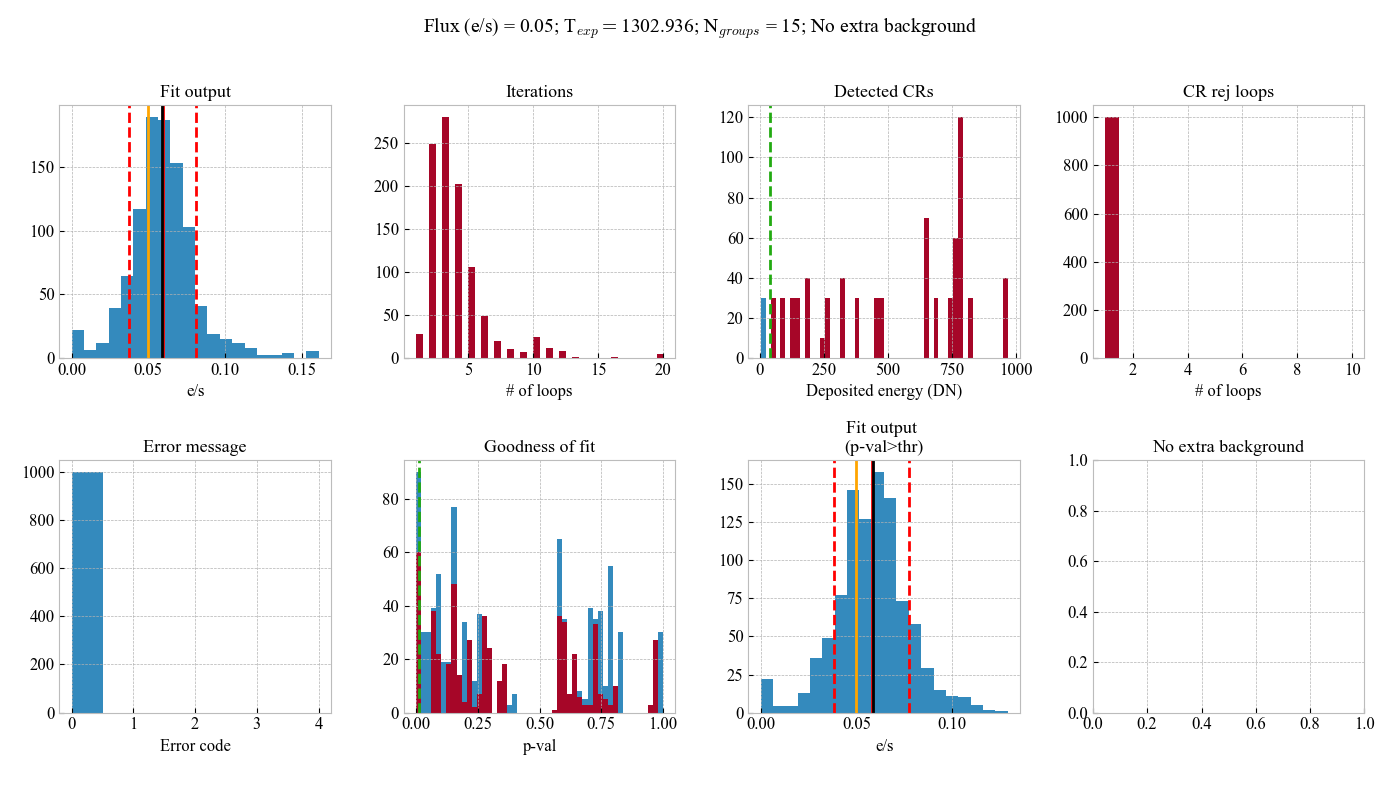

/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:114: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


######################
Input flux (e/s): 0.05
Exposure time 1302.936
Number of groups / frames / skips: 15 / 1 / 0
Number of tests: 1000
Fraction of good fits: 100.0 %
 
Pure Poisson / eff. RON / eff. quantization error / total relative error [% w.r.t. mean signal]: 12.389,  6.253,  0.181,   13.9
Pure Poisson / eff. RON / eff. quantization error / total error [e/s]:  0.0062,  0.0031,  0.0001,  0.0069
Standard deviation from "noiseless" counts (e/s):  0.0073
 
Output mean (e/s):  0.0593
Output median (e/s):  0.0592
Output standard deviation (e/s):  0.0220
Rel. % error: : 44.05
Rel. % bias:: 18.69
 
no-CR Output mean (e/s):  0.0553
no-CR Output median (e/s):  0.0546
no-CR Output standard deviation (e/s):  0.0142
no-CR Rel. % error: : 28.41
no-CR Rel. % bias:: 10.52
 
yes-CR Output mean (e/s):  0.0630
yes-CR Output median (e/s):  0.0617
yes-CR Output standard deviation (e/s):  0.0266
yes-CR Rel. % error: : 53.24
yes-CR Rel. % bias:: 25.93
 
Fraction of good fits at  0.010 confidence: 98.1

<IPython.core.display.Javascript object>


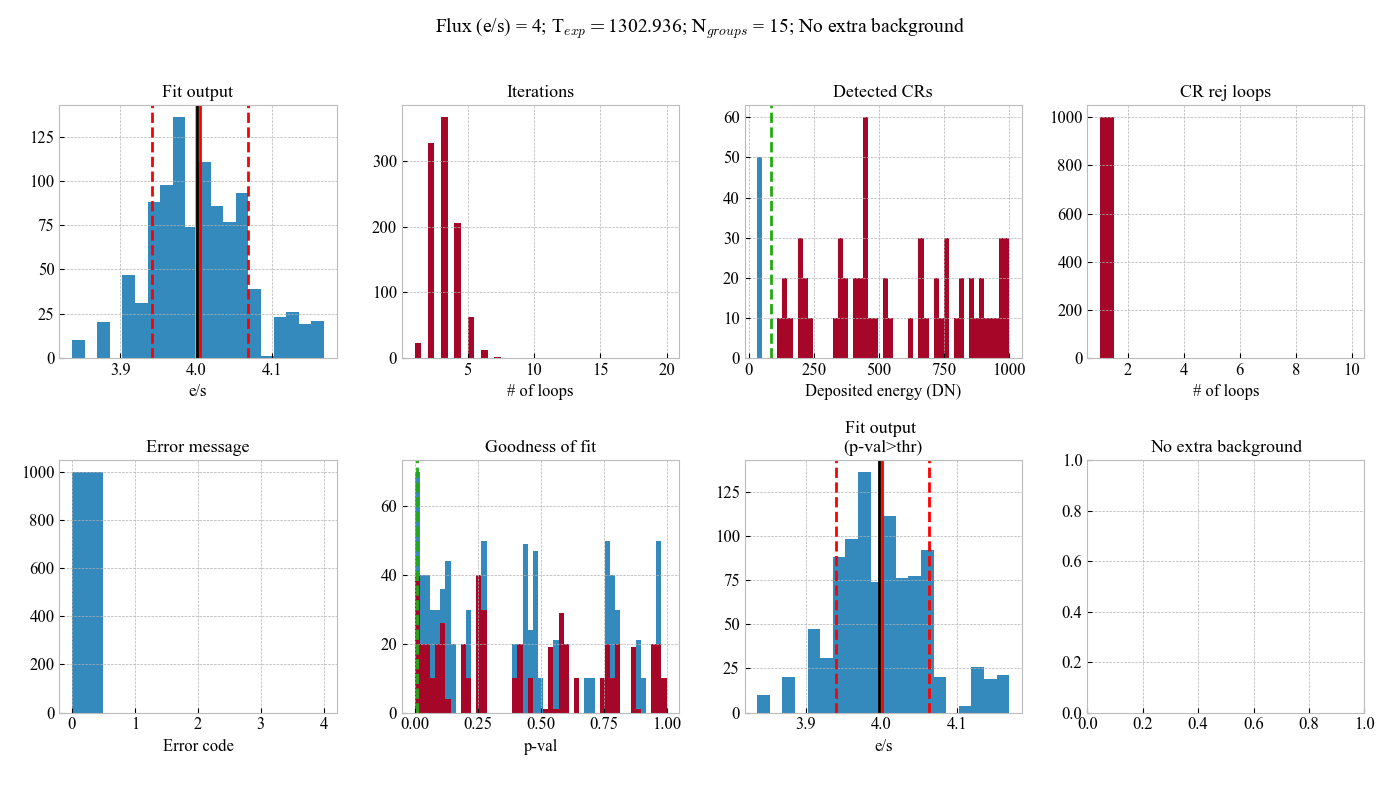

######################
Input flux (e/s): 4
Exposure time 1302.936
Number of groups / frames / skips: 15 / 1 / 0
Number of tests: 1000
Fraction of good fits: 100.0 %
 
Pure Poisson / eff. RON / eff. quantization error / total relative error [% w.r.t. mean signal]:  1.385,  0.078,  0.002,   1.39
Pure Poisson / eff. RON / eff. quantization error / total error [e/s]:  0.0554,  0.0031,  0.0001,  0.0555
Standard deviation from "noiseless" counts (e/s):  0.0604
 
Output mean (e/s):  4.0051
Output median (e/s):  4.0016
Output standard deviation (e/s):  0.0628
Rel. % error: :  1.57
Rel. % bias::  0.13
 
no-CR Output mean (e/s):  4.0011
no-CR Output median (e/s):  3.9980
no-CR Output standard deviation (e/s):  0.0646
no-CR Rel. % error: :  1.61
no-CR Rel. % bias::  0.03
 
yes-CR Output mean (e/s):  4.0092
yes-CR Output median (e/s):  4.0092
yes-CR Output standard deviation (e/s):  0.0606
yes-CR Rel. % error: :  1.51
yes-CR Rel. % bias::  0.23
 
Fraction of good fits at  0.010 confidence: 95.0 %


<IPython.core.display.Javascript object>


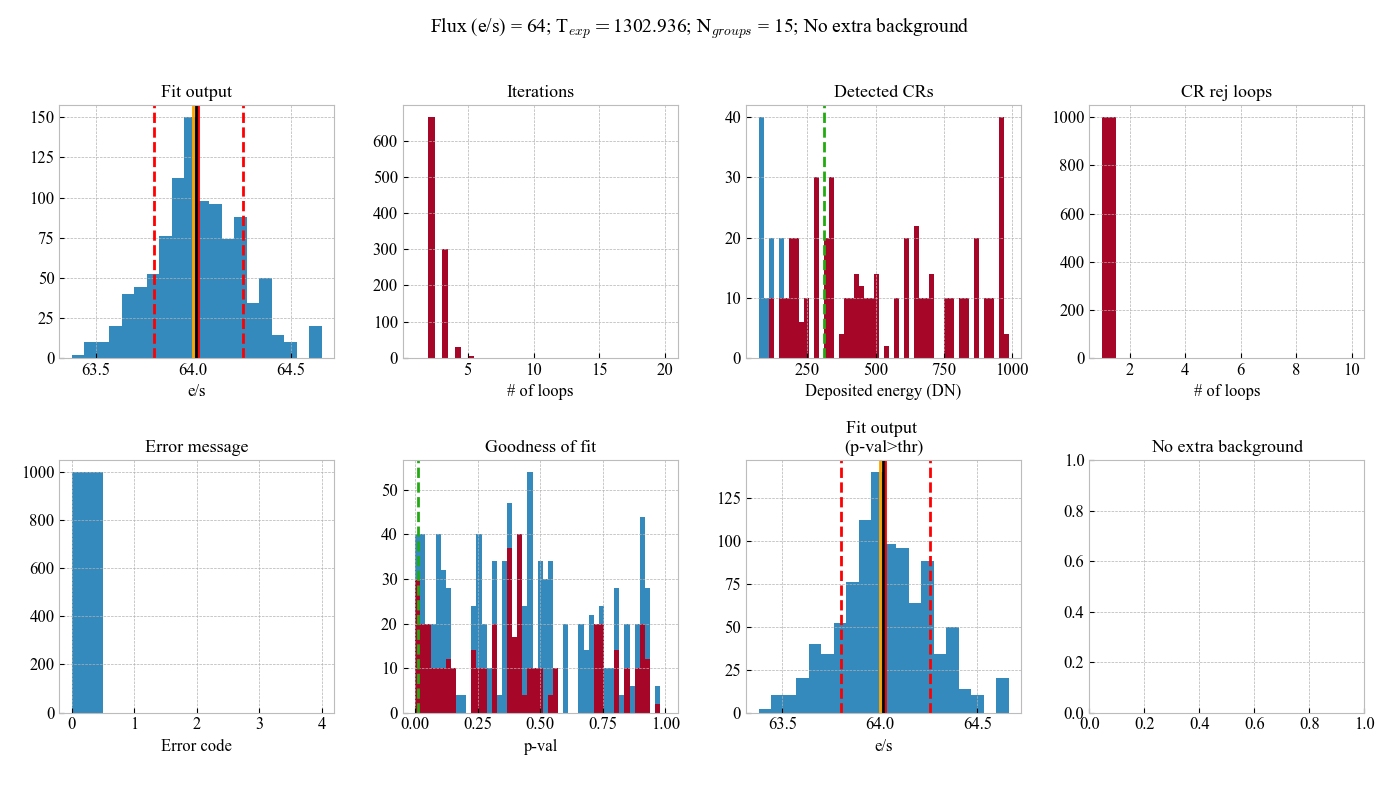

######################
Input flux (e/s): 64
Exposure time 1302.936
Number of groups / frames / skips: 15 / 1 / 0
Number of tests: 1000
Fraction of good fits: 100.0 %
 
Pure Poisson / eff. RON / eff. quantization error / total relative error [% w.r.t. mean signal]:  0.346,  0.005,  0.000,  0.346
Pure Poisson / eff. RON / eff. quantization error / total error [e/s]:  0.2216,  0.0031,  0.0001,  0.2217
Standard deviation from "noiseless" counts (e/s):  0.2159
 
Output mean (e/s): 64.0268
Output median (e/s): 64.0152
Output standard deviation (e/s):  0.2287
Rel. % error: :  0.36
Rel. % bias::  0.04
 
no-CR Output mean (e/s): 64.0079
no-CR Output median (e/s): 63.9748
no-CR Output standard deviation (e/s):  0.2198
no-CR Rel. % error: :  0.34
no-CR Rel. % bias::  0.01
 
yes-CR Output mean (e/s): 64.0522
yes-CR Output median (e/s): 64.0590
yes-CR Output standard deviation (e/s):  0.2377
yes-CR Rel. % error: :  0.37
yes-CR Rel. % bias::  0.08
 
Fraction of good fits at  0.010 confidence: 97.0 %

<IPython.core.display.Javascript object>


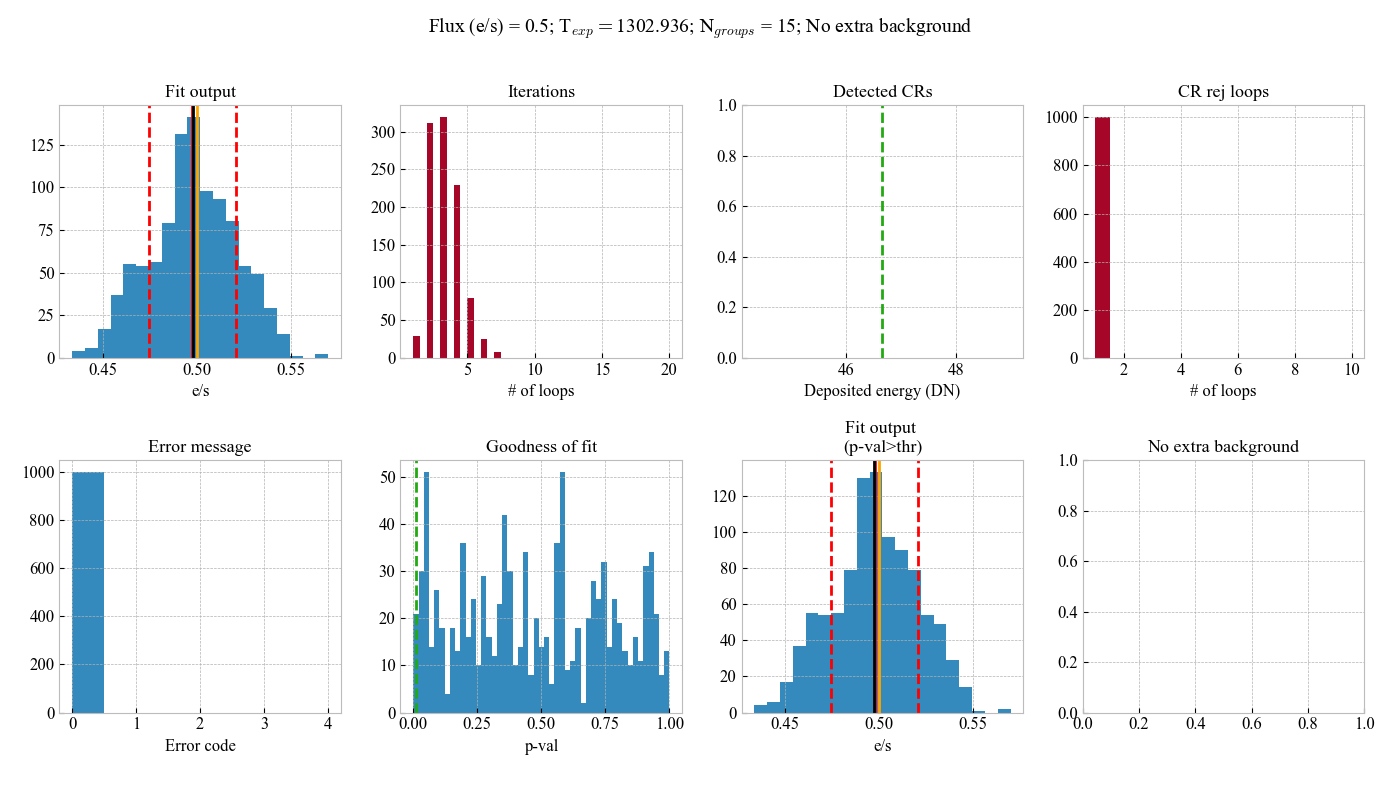

/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


######################
Input flux (e/s): 0.5
Exposure time 1302.936
Number of groups / frames / skips: 15 / 1 / 0
Number of tests: 1000
Fraction of good fits: 100.0 %
 
Pure Poisson / eff. RON / eff. quantization error / total relative error [% w.r.t. mean signal]:  3.918,  0.625,  0.018,   3.97
Pure Poisson / eff. RON / eff. quantization error / total error [e/s]:  0.0196,  0.0031,  0.0001,  0.0198
Standard deviation from "noiseless" counts (e/s):  0.0187
 
Output mean (e/s):  0.4978
Output median (e/s):  0.4981
Output standard deviation (e/s):  0.0229
Rel. % error: :  4.57
Rel. % bias:: -0.44
 
no-CR Output mean (e/s):  0.4978
no-CR Output median (e/s):  0.4981
no-CR Output standard deviation (e/s):  0.0229
no-CR Rel. % error: :  4.57
no-CR Rel. % bias:: -0.44
 
yes-CR Output mean (e/s):     nan
yes-CR Output median (e/s):     nan
yes-CR Output standard deviation (e/s):     nan
yes-CR Rel. % error: :   nan
yes-CR Rel. % bias::   nan
 
Fraction of good fits at  0.010 confidence: 98.5 

<IPython.core.display.Javascript object>


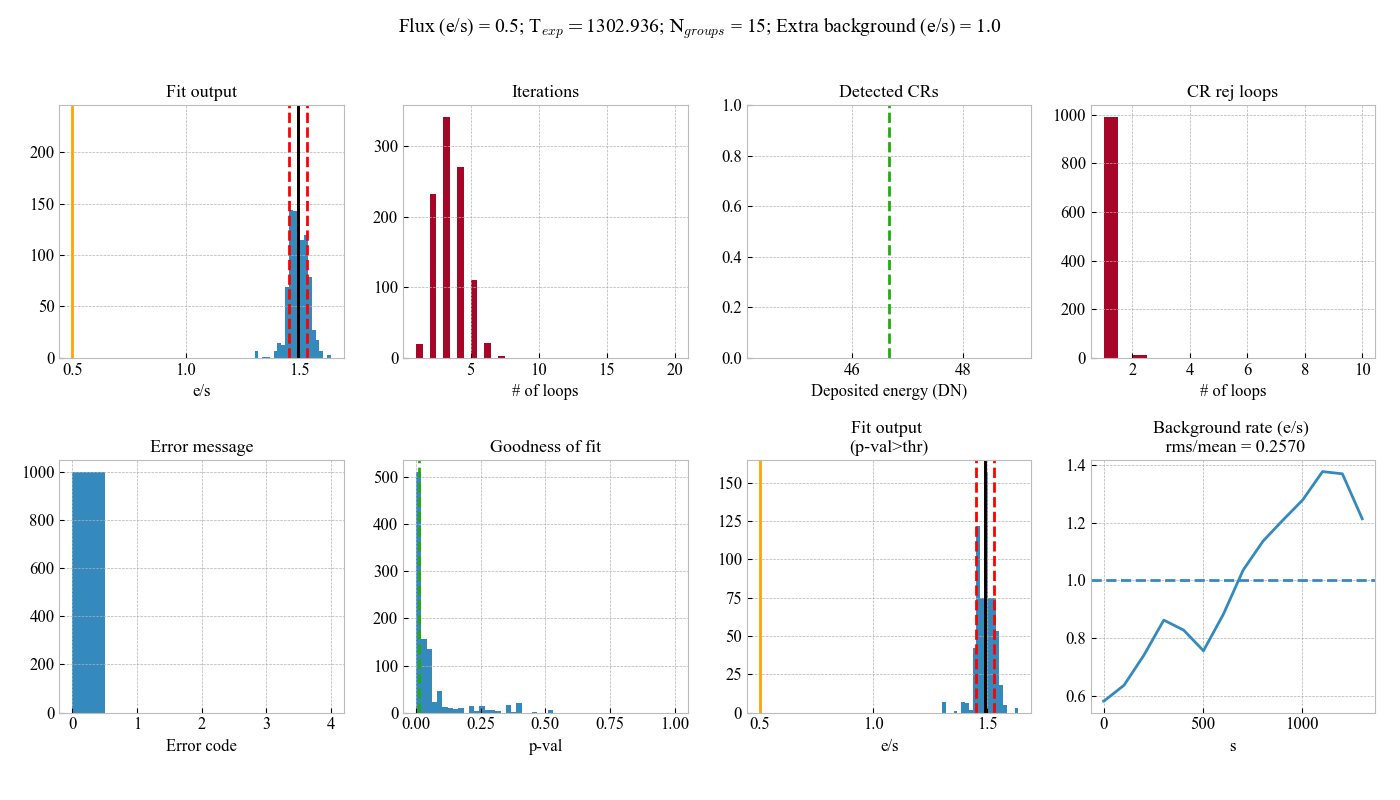

######################
Input flux (e/s): 0.5
Exposure time 1302.936
Number of groups / frames / skips: 15 / 1 / 0
Number of tests: 1000
Fraction of good fits: 100.0 %
 
Pure Poisson / eff. RON / eff. quantization error / total relative error [% w.r.t. mean signal]:  3.918,  0.625,  0.018,   3.97
Pure Poisson / eff. RON / eff. quantization error / total error [e/s]:  0.0196,  0.0031,  0.0001,  0.0198
Standard deviation from "noiseless" counts (e/s):  0.0326
 
Output mean (e/s):  1.4945
Output median (e/s):  1.4938
Output standard deviation (e/s):  0.0404
Rel. % error: :  8.08
Rel. % bias:: 198.91
 
no-CR Output mean (e/s):  1.4945
no-CR Output median (e/s):  1.4938
no-CR Output standard deviation (e/s):  0.0404
no-CR Rel. % error: :  8.08
no-CR Rel. % bias:: 198.91
 
yes-CR Output mean (e/s):     nan
yes-CR Output median (e/s):     nan
yes-CR Output standard deviation (e/s):     nan
yes-CR Rel. % error: :   nan
yes-CR Rel. % bias::   nan
 
Fraction of good fits at  0.010 confidence: 64.

In [9]:
for j,(myflux,myramp) in enumerate(zip(myfluxes,myramps)):
    
    BM0 = (error[:,j] == 0)
    mn = np.mean(outerate[BM0,j])
    md = np.median(outerate[BM0,j])
    st = np.std(outerate[BM0,j])

    f = plt.figure(figsize=(14,8))
    
    ax1 = f.add_subplot(241)
    ax1.hist(outerate[BM0,j],bins=20)
    ax1.axvline(myflux,color='orange')
    ax1.axvline(mn,color='red')
    ax1.axvline(mn-st,color='red',linestyle='--')
    ax1.axvline(mn+st,color='red',linestyle='--')
    ax1.axvline(md,color='black')
    ax1.set_title('Fit output',fontsize=13)
    ax1.set_xlabel('e/s')

    ax2 = f.add_subplot(242)
    n,b,p = ax2.hist(counter[:,j],bins=np.linspace(1,20,39))
    n,b,p = ax2.hist(counter[BM0,j],bins=b)
    ax2.set_title('Iterations',fontsize=13)
    ax2.set_xlabel('# of loops')
    
    rCRs = ramps_with_CRs[j]
    BM2 = BM0 & (~rCRs)
    mn2 = np.mean(outerate[BM2,j])
    md2 = np.median(outerate[BM2,j])
    st2 = np.std(outerate[BM2,j])

    BM3 = BM0 & rCRs
    mn3 = np.mean(outerate[BM3,j])
    md3 = np.median(outerate[BM3,j])
    st3 = np.std(outerate[BM3,j])

    
    ax3 = f.add_subplot(243)
    if allCRcounts[j].size >0 :
        n,b,p = ax3.hist(allCRcounts[j],bins=50)
        if allCRdetect[j].size >0 :
            n,b,p = ax3.hist(allCRcounts[j][allCRdetect[j]],bins=b)
    
    ax3.axvline(4*np.sqrt(myflux*np.mean(myramp.group_times[1:]-myramp.group_times[:-1])+2*np.square(meas_list[j][0].RON_adu)),color='#22aa12',linestyle='--')
    ax3.set_title('Detected CRs',fontsize=13)
    ax3.set_xlabel('Deposited energy (DN)')
    
    ax4 = f.add_subplot(244)
    n,b,p = ax4.hist(crloops_counter[:,j],bins=np.linspace(1,10,19))
    n,b,p = ax4.hist(crloops_counter[BM0,j],bins=b)
    ax4.set_title('CR rej loops',fontsize=13)
    ax4.set_xlabel('# of loops')

    ax5 = f.add_subplot(245)
    n,b,p = ax5.hist(error[:,j],bins=np.linspace(0,4,9))
    ax5.set_title('Error message',fontsize=13) 
    ax5.set_xlabel('Error code')

    ax6 = f.add_subplot(246)   
    pthr = 0.01
    n,b,p = ax6.hist(gof_pval[:,j][np.isfinite(gof_pval[:,j])],bins=np.linspace(0,1,50))
    n,b,p = ax6.hist(gof_pval[:,j][np.isfinite(gof_pval[:,j]) & (np.asarray([kk is not None for kk in CR_list[j]]))],bins=np.linspace(0,1,50))

    ax6.set_title('Goodness of fit',fontsize=13)
    ax6.axvline(pthr,color='#22aa12',linestyle='--')
    ax6.set_xlabel('p-val')

    
    
    BMpt = gof_pval[:,j] > pthr
    
    BM1 = BM0 & BMpt
    mn1 = np.mean(outerate[BM1,j])
    md1 = np.median(outerate[BM1,j])
    st1 = np.std(outerate[BM1,j])

    
    ax7 = f.add_subplot(247)
    ax7.hist(outerate[BM1,j],bins=20)
    ax7.axvline(myflux,color='orange')
    ax7.axvline(mn1,color='red')
    ax7.axvline(mn1-st1,color='red',linestyle='--')
    ax7.axvline(mn1+st1,color='red',linestyle='--')
    ax7.axvline(md1,color='black')
    ax7.set_title('Fit output \n(p-val>thr)',fontsize=13)
    ax7.set_xlabel('e/s')

    ax8 = f.add_subplot(248)

    if mybgs[j] is not None:
        mean_bg_electron_rate = mybgs[j]['mean_bg_er']
        bg_times = mybgs[j]['times']
        bg_electron_rate = mybgs[j]['vbg_er']

        bg_int = interp1d(bg_times,bg_electron_rate,'quadratic')
        varbg = bg_int(myramps[j].read_times)

        dt = myramp.read_times[-1]-myramp.read_times[0]
        t_avg = np.trapz(varbg,myramps[j].read_times) / dt
        varbg = varbg/t_avg * mean_bg_electron_rate
        a_rms = np.sqrt(np.trapz(np.square(varbg-mean_bg_electron_rate),myramps[j].read_times)/dt)

        ax8.set_title('Background rate (e/s) \n rms/mean ={:7.4f}'.format(a_rms/mean_bg_electron_rate),fontsize=13)
        ax8.set_xlabel('s')
        ax8.plot(myramp.read_times,varbg);
        ax8.axhline(mean_bg_electron_rate,linestyle='--')
        sts = r'Flux (e/s) = {}; T$_{{exp}} = ${}; N$_{{groups}}$ = {}; Extra background (e/s) = {}'.format(myflux,myramp.group_times[-1],myramp.ngroups,mean_bg_electron_rate)
    else:
        ax8.set_title('No extra background',fontsize=13)
        sts = r'Flux (e/s) = {}; T$_{{exp}} = ${}; N$_{{groups}}$ = {}; No extra background'.format(myflux,myramp.group_times[-1],myramp.ngroups)
        
        
    for ax in [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]:
        ax.set_axis_bgcolor('#FFFFFF')

    
    f.suptitle(sts, fontsize=14)
    f.tight_layout(rect=[0,0.03,1,.92])

    
    actual_counts = np.empty(len(meas_list[j]))
    for k in range(actual_counts.size):
        actual_counts[k] = meas_list[j][k].noiseless_counts[-1]
    
    
    exptime = myramp.group_times[-1] - myramp.group_times[0] 
    mean_signal = myflux * exptime
    poi_err = np.sqrt(mean_signal)
    act_poi_err = np.std(actual_counts)*meas_list[j][0].gain
    
    eff_RON = meas_list[j][0].effRON_e
    eff_qerr = np.sqrt(meas_list[j][0].gain*myramp.nframes/12) * eff_RON/meas_list[j][0].RON_e

    tot_noise = np.sqrt(np.sum(np.square(np.array([poi_err,eff_RON,eff_qerr]))))


    
    print('######################')
    print('Input flux (e/s):',myflux)
    print('Exposure time',exptime)
    print('Number of groups / frames / skips: {} / {} / {}'.format(myramp.ngroups,myramp.nframes,myramp.nskips))
    print('Number of tests:',ntest)
    print('Fraction of good fits:',100.*BM0.sum().astype(np.float_)/ntest,'%')
    print(' ')    
    print('Pure Poisson / eff. RON / eff. quantization error / total relative error [% w.r.t. mean signal]: {:6.3f}, {:6.3f}, {:6.3f}, {:6.3}'.format(
        100.*poi_err/mean_signal, 100.*eff_RON/mean_signal, 100.*eff_qerr/mean_signal, 100*tot_noise/mean_signal))
    print('Pure Poisson / eff. RON / eff. quantization error / total error [e/s]: {:7.4f}, {:7.4f}, {:7.4f}, {:7.4f}'.format(
        poi_err/exptime, eff_RON/exptime, eff_qerr/exptime, tot_noise/exptime))
    print('Standard deviation from "noiseless" counts (e/s): {:7.4f}'.format(act_poi_err/exptime))
    print(' ')
    print('Output mean (e/s): {:7.4f}'.format(mn))
    print('Output median (e/s): {:7.4f}'.format(md))
    print('Output standard deviation (e/s): {:7.4f}'.format(st))
    print('Rel. % error: : {:5.2f}'.format(100.*st/myflux))
    print('Rel. % bias:: {:5.2f}'.format(100.*(mn-myflux)/myflux))
    print(' ')
    print('no-CR Output mean (e/s): {:7.4f}'.format(mn2))
    print('no-CR Output median (e/s): {:7.4f}'.format(md2))
    print('no-CR Output standard deviation (e/s): {:7.4f}'.format(st2))
    print('no-CR Rel. % error: : {:5.2f}'.format(100.*st2/myflux))
    print('no-CR Rel. % bias:: {:5.2f}'.format(100.*(mn2-myflux)/myflux))
    print(' ')
    print('yes-CR Output mean (e/s): {:7.4f}'.format(mn3))
    print('yes-CR Output median (e/s): {:7.4f}'.format(md3))
    print('yes-CR Output standard deviation (e/s): {:7.4f}'.format(st3))
    print('yes-CR Rel. % error: : {:5.2f}'.format(100.*st3/myflux))
    print('yes-CR Rel. % bias:: {:5.2f}'.format(100.*(mn3-myflux)/myflux))
    print(' ')
    print('Fraction of good fits at {:6.3f} confidence: {} %'.format(pthr,100.*np.sum(BMpt)/len(BMpt)))
    print('p-flagged Output mean (e/s) {:7.4f}'.format(mn1))
    print('p-flagged Output median (e/s) {:7.4f}'.format(md1))
    print('p-flagged Output standard deviation (e/s) {:7.4f}'.format(st1))
    print('p-flagged Rel. % error: {:5.2f}'.format(100.*st1/myflux))
    print('p-flagged Rel. % bias: {:5.2f}'.format(100.*(mn1-myflux)/myflux))
    print(' ')
    print('CR hits / detected',len(allCRcounts[j]),'/',np.sum(allCRdetect[j]))
    print('CR - false positives',np.sum(CR_false_positives[j]))
    

#### Detailed plots to examine the false positive cases

#### Detailed plots to examine the bad fit (ERR > 0) cases

In [10]:
RM = meas_list[2][0]

print(RM.RTS.group_times)

dt    = np.zeros_like(RM.noisy_counts,dtype=np.float_)
dtint    = np.zeros_like(RM.noisy_counts)
triangle_sums = np.zeros_like( RM.noisy_counts)
for i in range(1,dt.size):
    dt[i] = RM.RTS.group_times[i] - RM.RTS.group_times[i-1] 
    dtint[i] = RM.RTS.group_times[i] - RM.RTS.group_times[i-1] 
    
    triangle_sums[i] = RM.RTS.lower_triangle_sum[i] + RM.RTS.lower_triangle_sum[i-1]


x_hat = np.floor(RM.noisy_counts*RM.gain)
        
for i in range(1,x_hat.size):
    if x_hat[i] < x_hat[i-1]:
        x_hat[i] = x_hat[i-1]

x_hat = x_hat+np.mean(RM.noisy_counts*RM.gain)-np.mean(x_hat)

print(RM.noisy_counts)
print(x_hat)

electron_rates = (x_hat[1:]-x_hat[:-1])/dt[1:]
mean_electron_rate = np.median(electron_rates) 

print(electron_rates)
print(mean_electron_rate)
print(dt)
print(dtint)
#gi_list[2][0]

[    0.        2.932   102.933   202.933   302.933   402.934   502.934
   602.934   702.935   802.935   902.935  1002.936  1102.936  1202.936
  1302.936]
[11051 11128 14030 16919 20106 22979 25862 28718 31554 34406 37280 40210
 43089 45937 48811]
[  24610.47733333   24782.47733333   31244.47733333   37678.47733333
   44776.47733333   51174.47733333   57594.47733333   63954.47733333
   70270.47733333   76622.47733333   83022.47733333   89547.47733333
   95959.47733333  102301.47733333  108702.47733333]
[ 58.66302865  64.61935381  64.34        70.98        63.97936021  64.2
  63.6         63.15936841  63.52        64.          65.24934751  64.12
  63.42        64.01      ]
64.005
[   0.       2.932  100.001  100.     100.     100.001  100.     100.
  100.001  100.     100.     100.001  100.     100.     100.   ]
[  0   2 100  99 100 100 100  99 100 100 100 100  99 100 100]


In [39]:
print(outerate_l[0])
print(outerate_l[10])
print(outerate_l[20])

0.029228756525
0.029228756525
0.029228756525


In [40]:
print(goodints_l[0])
print(goodints_l[10])
print(goodints_l[20])


[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True]


In [41]:
print(counter_l[0])
print(counter_l[10])
print(counter_l[20])


2
2
2


In [43]:
print(meas_l[0].noisy_counts)
print(meas_l[10].noisy_counts)
print(meas_l[20].noisy_counts)


[11114 11102 11106 11109 11111 11110 11118 11113 11123 11130 11125 11125
 11130 11132 11130]
[11114 11102 11106 11109 11111 11110 11118 11113 11123 11130 11125 11125
 11130 11132 11130]
[11114 11102 11106 11109 11111 11110 11118 11113 11123 11130 11125 11125
 11130 11132 11130]


In [42]:
print(meas_l[0].noisy_counts[1:]  - meas_l[0].noisy_counts[:-1])
print(meas_l[10].noisy_counts[1:] - meas_l[10].noisy_counts[:-1])
print(meas_l[20].noisy_counts[1:] - meas_l[20].noisy_counts[:-1])

[-12   4   3   2  -1   8  -5  10   7  -5   0   5   2  -2]
[-12   4   3   2  -1   8  -5  10   7  -5   0   5   2  -2]
[-12   4   3   2  -1   8  -5  10   7  -5   0   5   2  -2]


In [31]:
outerate_l

[0.029228756524984866,
 0.051534905953542758,
 0.075993159205524019,
 0.064161880539426411,
 0.06230338121771966,
 0.05076565364644238,
 0.04615065645730243,
 0.069995163703729824,
 0.054162583786238692,
 0.034164091783935292,
 0.029228756524984866,
 0.051534905953542758,
 0.075993159205524019,
 0.064161880539426411,
 0.06230338121771966,
 0.05076565364644238,
 0.04615065645730243,
 0.069995163703729824,
 0.054162583786238692,
 0.034164091783935292,
 0.029228756524984866,
 0.051534905953542758,
 0.075993159205524019,
 0.064161880539426411,
 0.06230338121771966,
 0.05076565364644238,
 0.04615065645730243,
 0.069995163703729824,
 0.054162583786238692,
 0.034164091783935292,
 0.029228756524984866,
 0.051534905953542758,
 0.075993159205524019,
 0.064161880539426411,
 0.06230338121771966,
 0.05076565364644238,
 0.04615065645730243,
 0.069995163703729824,
 0.054162583786238692,
 0.034164091783935292,
 0.029228756524984866,
 0.051534905953542758,
 0.075993159205524019,
 0.064161880539426411,
